# 📋 **Student Information**

*Complete the required fields below with your personal and W&B account details.*

In [ ]:
FIRST_NAME = "Kooshan" # replace with your first name
LAST_NAME = "Fattah" # replace with your last name
STUDENT_ID = 401102191 # replace with your student id
WANDB_ID = "kooshannasa25-sharif" # replace with your wandb username
PROJECT_NAME = f"{FIRST_NAME}-{LAST_NAME}-DQN-EXPLORE-HW"
print(f"Project name: {PROJECT_NAME}")

In [ ]:
print(f"Check my results at https://wandb.ai/{WANDB_ID}/{PROJECT_NAME}")

In [ ]:
# Set DEBUG to True if you are still implementing the code and debugging
# and don't want to make your wandb dashboard messy.
# set DEBUG to False if you are almost done with the implementation
# and want check performance and compare hyperparameters and models
DEBUG = False

# 📘 Guidelines

> ⚠️ **Please read this section carefully before proceeding.**

### 🔧 Install Dependencies

In [ ]:
!apt install build-essential python3-dev
!git clone https://github.com/DeepRLCourse/Homework-10.git
%pip install swig
%pip install "Homework-10/BootstrapDQN"

### 📊 Weights & Biases (W&B) Integration

Follow these steps to set up tracking with [Weights & Biases](https://wandb.ai/site/):

1. [Create a W&B account](https://wandb.ai/site/).
2. Set the `WANDB_ID` variable in the **Student Information** section to your W&B username.
3. Create a new project using the name defined in the `PROJECT_NAME` variable. Ensure the project visibility is set to **Public**.
4. [Retrieve your W&B API key](https://docs.wandb.ai/support/find_api_key/).
5. Set the `WANDB_API_KEY`:
   - As a **secret** if you're using **Google Colab** or **Kaggle**
   - As an **environment variable** if running locally

#### 💻 Platform-Specific Setup

##### Google Colab


> You only need to add the secret — no code changes are required.

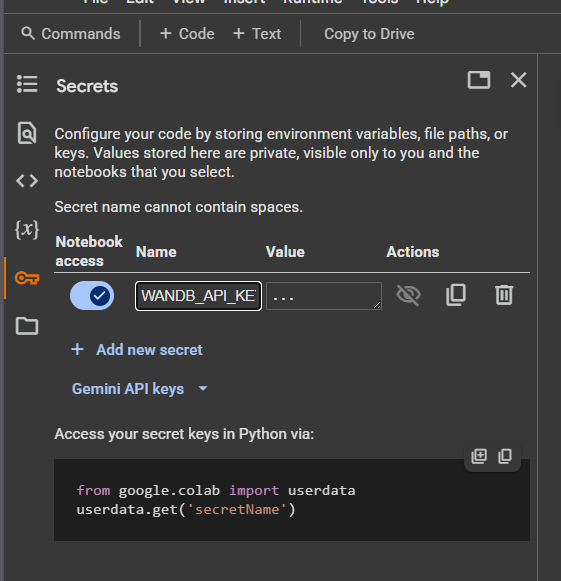

#### Kaggle

To configure W&B API key in Kaggle:

- Go to: `Add-ons` → `Secrets` → `Add Secret`
- **Label:** `WANDB_API_KEY`  
- **Value:** `<your_api_key>`

> You only need to add the secret — no code changes are required.

#### Local

You can set the `WANDB_API_KEY` as an environment variable manually or,

store it in a `.env` file:
```bash
# secrets.env
WANDB_API_KEY=your_api_key
```
and then run the following cell:

In [ ]:
from bootstrapdqn import get_machine
if get_machine() == "Local Machine":
    import dotenv
    dotenv.load_dotenv(".workspace/secrets.env") # give it the path to your secrets.env file

### 📤 Submission Requirements

In addition to submitting this notebook on **Quera**, you must:

- Have a W&B project matching the name in `PROJECT_NAME`, under the account defined by `WANDB_ID`
- Ensure the W&B link displayed in the **Student Information** section is valid
- Tag your final experiment run for **each algorithm** with `Final`:
  - Go to **Runs** (left sidebar) → **Tags** → Add the tag `Final`
  - A total of **four** runs should be tagged as `Final`

⚠️ **Important:** The `save_code` option must remain enabled. If a `Final` run does not include saved code, it will **not** be graded.

### 🧮 Grading Criteria

The score for each algorithm is provided in its respective section. This score is then multiplied by the environment score:
- `CartPole`: × 0.1
    - Minimum requirement: over 200 points across 5 consecutive evaluations
- `LunarLander`: × 0.7
    - Minimum requirement: over 200 points across 5 consecutive evaluations
- `MountainCar`: × 1.0
    - Minimum requirement: reach the goal state across 5 consecutive evaluations
- `FrozenLake`: × 1.2
    - Minimum requirement: reach the goal state across at least 5 evaluations of 15 consecutive evaluations
- `SeaQuest`: × 1.5
    -  Minimum requirement: over 2000 points across 5 consecutive evaluations

Total Score is 100. you can get up to 80 bonus score (180)

### 📝 Implementation Guide

- Implement the algorithms as subclasses of `BaseDQNAgent` provided in [`base_agent.py`](https://github.com/DeepRLCourse/Homework-10/blob/main/BootstrapDQN/src/bootstrapdqn/base_agent.py). You may add or override methods/properties as needed.
    - The `BaseDQNAgent` code will be automatically downloaded and imported. Ensure you review it carefully before implementing your algorithms.
- Code blocks or lines marked with `# DO NOT CHANGE` must remain unaltered in your final submission. You may modify them during development for debugging purposes, but revert them before submitting.
- If running locally, real-time W&B logging might face restrictions. Use W&B's offline mode for experiments and sync them later using the `wandb sync` command ([link](https://docs.wandb.ai/support/run_wandb_offline/)).
- Prioritize vector operations over loops for better performance. While algorithm descriptions might use loops for clarity, only the main training and rollout loops (implemented in `BaseDQNAgent`) should remain iterative. Failure to vectorize may significantly increase convergence time.
- For potentially more stable and faster training, you may consider using *Smooth L1 Loss* instead of Mean Squared Error. (Optional)
- Weight initialization significantly impacts performance. Orthogonal initialization is generally recommended in the RL community and might be worth trying.


### 💡 Tips & More

The following resource provides general advice for implementing and debugging RL algorithms (not required for this homework, but highly recommended):

- [Debugging RL, Without the Agonizing Pain](https://andyljones.com/posts/rl-debugging.html)

# 🧭 Exploration Techniques in DQN

## 🚀 Initialization


In [ ]:
# DO NOT CHANGE THIS BLOCK
from bootstrapdqn import ReplayBuffer, BaseDQNAgent, get_machine, set_wandb_key_form_secrets, envs
import torch
from torch import nn
import wandb
import random
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

In [ ]:
# DO NOT CHANGE THIS BLOCK
TA = True if WANDB_ID == "alireza9" else False
SAVE_CODE = False if TA else True

In [ ]:
# DO NOT CHANGE THIS BLOCK
# IF YOU CHANGE ANYTHING ABOUT ENVIRONMENTS AND THEIR RUN CONFIGS, YOUR CODE WILL NOT BE GRADED
from pprint import pprint
ENVS = envs()
pprint(ENVS)

In [ ]:
if not DEBUG:
    set_wandb_key_form_secrets()

## 💻 Algorithms Implementation

### Epsilon Greedy DQN

Consider the following implementation as a reference for implementing other algorithms.

You can also use it as a baseline for comparing the performance of subsequent algorithms.

In [ ]:
class EpsGreedyDQNAgent(BaseDQNAgent):
    """
    Epsilon-greedy DQN agent.
    """

    def __init__(self, epsilon: float = 0.1, eps_decay: float = 0.999, eps_min: float = 0.01, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min

    def _decay_eps(self):
        """
        Decay the epsilon value.
        """
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

    def _create_replay_buffer(self, max_size=1000000):
        self.replay_buffer = ReplayBuffer(
            [
                ("state", (self.env.observation_space.shape[0],), torch.float32),
                ("action", (), torch.int64),
                ("reward", (), torch.float32),
                ("next_state", (self.env.observation_space.shape[0],), torch.float32),
                ("done", (), torch.float32),
            ],
            max_size=max_size,
            device=self.device,
        )

    def _create_network(self):
        self.q_network = nn.Sequential(
            nn.Linear(self.env.observation_space.shape[0], 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.env.action_space.n),
        ).to(self.device)
        self.q_network.apply(
            lambda m: torch.nn.init.orthogonal_(m.weight, gain=torch.nn.init.calculate_gain("relu"))
            if isinstance(m, nn.Linear)
            else None
        )
        self.target_network = nn.Sequential(
            nn.Linear(self.env.observation_space.shape[0], 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, self.env.action_space.n),
        ).to(self.device)

    def _compute_loss(self, batch):
        """
        Compute the loss for the DQN agent.
        """
        states = batch["state"]
        actions = batch["action"]
        rewards = batch["reward"]
        next_states = batch["next_state"]
        dones = batch["done"]

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        next_q_values = self.target_network(next_states).max(1)[0]
        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.SmoothL1Loss()(q_values, expected_q_values)
        return loss

    def _act_in_training(self, state):
        """
        Select an action during training.
        """
        self._decay_eps()
        if torch.rand(1).item() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device))
                return q_values.argmax().item()

    def _act_in_eval(self, state):
        """
        Select an action during evaluation.
        """
        with torch.no_grad():
            q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device))
            return q_values.argmax().item()

    def _wandb_train_step_dict(self):
        log_dict = super()._wandb_train_step_dict()
        log_dict["train_step/epsilon"] = self.epsilon
        return log_dict

    def _save_dict(self):
        save_dict = super()._save_dict()
        save_dict["epsilon"] = self.epsilon
        save_dict["eps_decay"] = self.eps_decay
        save_dict["eps_min"] = self.eps_min
        return save_dict


### Bootstrap DQN

> Paper: [Deep Exploration via Bootstrapped DQN](https://arxiv.org/abs/1602.04621)

**40 Points**

#### Details

In this algorithm, instead of using a single network, we maintain an ensemble of networks (or a single network with multiple heads). At the start of each training episode, we randomly select one of these networks (heads) and use it to choose actions for the entire episode. This strategy approximates Thompson Sampling for the K-armed Bandit problem, enabling deeper exploration by leveraging the diversity among the ensemble members.

#### Implementation

In [ ]:
import copy
import torch
import torch.nn as nn
import random

class MultiHeadQNet(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, K: int):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.K = K

        # Shared feature extractor
        self.shared = nn.Sequential(
            nn.Linear(self.obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )

        # K output heads for bootstrapped Q-value predictions
        self.heads = nn.ModuleList([nn.Linear(256, self.action_dim) for _ in range(self.K)])

        # Apply orthogonal initialization to all linear layers
        def orth_init(m):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain("relu"))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        self.shared.apply(orth_init)
        for head in self.heads:
            head.apply(orth_init)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.shared(x)  # Extract shared features
        head_outputs = [head(features) for head in self.heads]  # Compute each head's Q-values
        return torch.stack(head_outputs, dim=1)  # Stack to shape (batch, K, action_dim)


class BootstrapDQNAgent(EpsGreedyDQNAgent):
    def __init__(self, k: int = 10, bernoulli_p: float = 0.5, **kwargs):
        self.k = k
        self.bernoulli_p = bernoulli_p
        self.bernoulli_dist = torch.distributions.Bernoulli(torch.tensor(self.bernoulli_p))
        self.current_head = 0  # Head index for current episode
        super().__init__(**kwargs)

    def _create_network(self):
        obs_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.n
        self.q_network = MultiHeadQNet(obs_dim, action_dim, self.k).to(self.device)
        self.target_network = copy.deepcopy(self.q_network).to(self.device)

    def _create_replay_buffer(self, max_size=1000000):
        self.replay_buffer = ReplayBuffer(
            [
                ("state", (self.env.observation_space.shape[0],), torch.float32),
                ("action", (), torch.int64),
                ("reward", (), torch.float32),
                ("next_state", (self.env.observation_space.shape[0],), torch.float32),
                ("done", (), torch.float32),
                ("mask", (self.k,), torch.float32),
            ],
            max_size=max_size,
            device=self.device,
        )

    def _preprocess_add(self, state, action, reward, next_state, done):
        data = super()._preprocess_add(state, action, reward, next_state, done)
        data["mask"] = self.bernoulli_dist.sample((self.k,)).to(self.device).float()
        return data

    def _compute_loss(self, batch):
        states = batch["state"]
        actions = batch["action"]
        rewards = batch["reward"]
        next_states = batch["next_state"]
        dones = batch["done"]
        masks = batch["mask"]

        B = states.shape[0]
        gamma = self.gamma

        q_all = self.q_network(states)
        idx = actions.unsqueeze(1).unsqueeze(2).expand(-1, self.k, 1)
        q_taken = q_all.gather(dim=2, index=idx).squeeze(2)

        next_q_all = self.target_network(next_states)
        next_max = next_q_all.max(dim=2)[0]

        target = rewards.unsqueeze(1) + (1.0 - dones.unsqueeze(1)) * gamma * next_max
        td_error = q_taken - target.detach()
        loss_per_head = td_error.pow(2) * masks

        total_active = masks.sum()
        if total_active.item() < 1e-8:
            return torch.tensor(0.0, device=self.device, requires_grad=True)

        return loss_per_head.sum() / (total_active + 1e-8)

    def _episode(self):
        self.current_head = random.randrange(self.k)  # Select random head
        super()._episode()

    def _act_in_training(self, state):
        self._decay_eps()
        if torch.rand(1).item() < self.epsilon:
            return self.env.action_space.sample()

        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            q_vals = self.q_network(s)
            return q_vals[0, self.current_head].argmax().item()

    def _act_in_eval(self, state):
        with torch.no_grad():
            s = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            q_vals = self.q_network(s).mean(dim=1)
            return q_vals.argmax(dim=1).item()

    def _wandb_train_episode_dict(self):
        log_dict = super()._wandb_train_episode_dict()
        log_dict["train/episode_head_index"] = float(self.current_head)
        return log_dict

    def _save_dict(self):
        save_dict = super()._save_dict()
        save_dict["k"] = self.k
        save_dict["bernoulli_p"] = self.bernoulli_p
        return save_dict


### Bootstrap DQN with Randomized Prior Function

> Paper: [Randomized Prior Functions for Deep Reinforcement Learning](https://arxiv.org/abs/1806.03335)

**25 Points**

#### Details

This method is very similar to Bootstrap DQN, but introduces additional **non-trainable** networks (with multiple heads) called random priors. These priors are added to the Q-network outputs to encourage diversity among ensemble members, both across states and over time. During training, the Q-networks learn to compensate for the effect of these fixed random priors, which helps maintain exploration.

##### Notes
- Random prior networks are typically smaller (narrower and shallower) than the main Q-networks, so the Q-networks tend to distill their influence during training.
- There is a $\delta_\mathrm{RPF}$ coefficient to control the strength of the random priors, but for simplicity, you can set $\delta_\mathrm{RPF}=1$ and omit tuning this hyperparameter.

#### Implementation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class PriorMultiHeadQNet(nn.Module):
    def __init__(self, obs_dim: int, prior_hidden_dim: int, action_dim: int, k: int):
        super().__init__()
        self.k = k

        self.fc1 = nn.Linear(obs_dim, prior_hidden_dim)

        self.heads = nn.ModuleList(
            [nn.Linear(prior_hidden_dim, action_dim) for _ in range(k)]
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain("relu"))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.fc1(x))
        batch_size = x.size(0)
        action_dim = self.heads[0].out_features

        out = x.new_zeros(batch_size, self.k, action_dim)
        for j in range(self.k):
            out[:, j, :] = self.heads[j](h)
        return out

class RPFBootstrapDQNAgent(BootstrapDQNAgent):
    def __init__(
        self,
        k: int = 10,
        bernoulli_p: float = 0.5,
        prior_hidden_dim: int = 256,
        **kwargs
    ):
        self.k = k
        self.prior_hidden_dim = prior_hidden_dim

        super().__init__(k=k, bernoulli_p=bernoulli_p, **kwargs)
        self.delta_rpf = 1.0
        assert hasattr(self, "prior_network"), "Expected prior_network to be created in _create_network()"
        self.prior_network.eval()
        for p in self.prior_network.parameters():
            p.requires_grad = False
    def _create_network(self):
        super()._create_network()
        obs_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.n
        ph = self.prior_hidden_dim

        self.prior_network = PriorMultiHeadQNet(
            obs_dim=obs_dim,
            prior_hidden_dim=ph,
            action_dim=action_dim,
            k=self.k
        ).to(self.device)
        self.prior_network.eval()
        for param in self.prior_network.parameters():
            param.requires_grad = False
    def _act_in_training(self, state: torch.Tensor) -> int:
        self._decay_eps()

        if torch.rand(1).item() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                s = state.unsqueeze(0)
                q_all = self.q_network(s)
                p_all = self.prior_network(s)
                combined = q_all + self.delta_rpf * p_all
                q_head = combined[0, self.current_head, :]
                return int(q_head.argmax().item())
    def _act_in_eval(self, state: torch.Tensor) -> int:
        with torch.no_grad():
            s = state.unsqueeze(0)
            q_all = self.q_network(s)
            p_all = self.prior_network(s)
            combined = q_all + self.delta_rpf * p_all
            q_head = combined[0, self.current_head, :]
            return int(q_head.argmax().item())
    def _compute_loss(self, batch: dict) -> torch.Tensor:
        states      = batch["state"]
        actions     = batch["action"]
        rewards     = batch["reward"]
        next_states = batch["next_state"]
        dones       = batch["done"]
        masks       = batch["mask"]
        B = states.size(0)
        k = self.k
        gamma = self.gamma
        δ = self.delta_rpf
        q_all = self.q_network(states)
        p_all = self.prior_network(states)
        combined_q = q_all + δ * p_all
        a_exp = actions.unsqueeze(1).expand(-1, k).unsqueeze(2)
        q_taken = combined_q.gather(dim=2, index=a_exp).squeeze(2)

        with torch.no_grad():
            q_target_all = self.target_network(next_states)
            p_next_all   = self.prior_network(next_states)
            combined_next = q_target_all + δ * p_next_all
            next_max, _   = combined_next.max(dim=2)
        r_exp = rewards.unsqueeze(1).expand(-1, k)
        d_exp = dones.unsqueeze(1).expand(-1, k)
        targets = r_exp + gamma * (1.0 - d_exp) * next_max
        loss_per_sample = F.smooth_l1_loss(q_taken, targets, reduction="none")
        masked_loss = loss_per_sample * masks
        head_sums   = masked_loss.sum(dim=0)
        head_counts = masks.sum(dim=0).clamp(min=1e-6)
        per_head_loss = head_sums / head_counts
        total_loss = per_head_loss.mean()
        return total_loss
    def _episode(self):

        super()._episode()
        self.current_head = random.randrange(self.k)

    def _wandb_train_episode_dict(self) -> dict:
        log_dict = super()._wandb_train_episode_dict()
        log_dict["train_episode/current_head"] = self.current_head
        return log_dict

    def _save_dict(self) -> dict:
        save_dict = super()._save_dict()
        save_dict["delta_rpf"] = self.delta_rpf
        return save_dict


### Uncertainty Estimation for Sample Efficient RPF Bootstrap DQN

> Paper: [Sample Efficient Deep Reinforcement Learning via Uncertainty Estimation](https://arxiv.org/abs/2201.01666)

**35 Points**

#### Details

This method does not explicitly address the exploration problem but focuses on improving sample efficiency.

By maintaining an ensemble of Q-networks, multiple Q-values can be computed for each state-action pair. This enables the estimation of uncertainty in the target values. Using this uncertainty, a weighted loss is calculated, where the weights are inversely proportional to the uncertainty. The more confident we are about a target, the higher its weight during the update.

#### Bonus

1. Use the minimum Effective Batch Size (EBS) as a hyperparameter instead of $\xi$, and numerically calculate $\xi$ during each training step based on the minimum EBS. (5 points)
2. Implement the complete IV-DQN algorithm as described in the appendix of the original paper. (15 points)

#### Implementation

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

class UEBootstrapDQNAgent(RPFBootstrapDQNAgent):
    def __init__(self, xi: float = 0.5, **kwargs):
        # Uncertainty estimation parameter for weighting variance-based uncertainty
        self.xi = xi
        super().__init__(**kwargs)

    def _compute_loss(self, batch: dict) -> torch.Tensor:
        # Extract batch components
        states      = batch["state"]
        actions     = batch["action"]
        rewards     = batch["reward"]
        next_states = batch["next_state"]
        dones       = batch["done"]
        masks       = batch["mask"]

        # Get batch dimensions and hyperparameters
        B = states.size(0)  # Batch size
        k = self.k          # Number of bootstrap heads
        gamma = self.gamma  # Discount factor
        δ = self.delta_rpf  # RPF scaling parameter
        ξ = self.xi         # Uncertainty estimation parameter
        eps = 1e-6          # Small epsilon for numerical stability

        # FrozenLake-specific parameters
        reward_scale = 10.0        # Scale sparse rewards for better learning
        exploration_bonus = 0.1    # Small bonus for non-terminal states
        uncertainty_threshold = 0.5 # Threshold for high uncertainty states

        # Forward pass through main networks to get Q-values and priors
        q_main_all = self.q_network(states)      # Shape: (B, k, num_actions)
        p_all      = self.prior_network(states)  # Shape: (B, k, num_actions)

        # Combine Q-values with scaled prior network outputs (RPF mechanism)
        combined_current = q_main_all + δ * p_all

        # Gather Q-values for the actions that were actually taken
        a_expanded = actions.unsqueeze(1).expand(-1, k).unsqueeze(2)  # Shape: (B, k, 1)
        q_taken = combined_current.gather(dim=2, index=a_expanded).squeeze(2)  # Shape: (B, k)

        # Compute target values (no gradients needed for target network)
        with torch.no_grad():
            # Get target Q-values and next state priors
            q_target_all = self.target_network(next_states)  # Shape: (B, k, num_actions)
            p_next_all   = self.prior_network(next_states)   # Shape: (B, k, num_actions)

            # Combine target Q-values with scaled priors
            combined_next = q_target_all + δ * p_next_all

            # Select best actions for each head (Double DQN style action selection)
            a_prime = combined_next.argmax(dim=2)  # Shape: (B, k)

            # Compute epistemic uncertainty via variance across bootstrap heads
            sigma_sq = torch.zeros(B, k, device=states.device)
            for j in range(k):
                # For each head j, get the Q-value of its chosen action across all heads
                a_prime_j = a_prime[:, j]  # Best action chosen by head j
                a_exp_forvar = a_prime_j.unsqueeze(1).expand(-1, k)  # Expand for all heads

                # Gather Q-values for action chosen by head j across all heads
                x_jbl = combined_next.gather(
                    dim=2,
                    index=a_exp_forvar.unsqueeze(2)
                ).squeeze(2)  # Shape: (B, k)

                # Compute variance across heads for this action
                sigma_sq[:, j] = torch.var(x_jbl, dim=1, unbiased=False)

            # Get the actual target Q-values using the selected actions
            combined_target_max = combined_next.gather(
                dim=2,
                index=a_prime.unsqueeze(2)
            ).squeeze(2)  # Shape: (B, k)

        # FrozenLake-specific reward shaping for sparse rewards
        r_expanded = rewards.unsqueeze(1).expand(-1, k)    # Expand rewards for all heads
        d_expanded = dones.unsqueeze(1).expand(-1, k)      # Expand done flags for all heads

        # Add exploration bonus for non-terminal transitions to combat sparsity
        # This helps the agent learn from intermediate states
        exploration_reward = torch.where(
            (r_expanded == 0) & (d_expanded == 0),  # Non-terminal, non-reward states
            exploration_bonus,                       # Small positive reward
            torch.zeros_like(r_expanded)            # No bonus otherwise
        )

        # Scale up actual rewards to make them more significant
        shaped_rewards = r_expanded * reward_scale + exploration_reward

        # Compute TD targets using shaped rewards
        targets = shaped_rewards + gamma * (1.0 - d_expanded) * combined_target_max

        # Compute TD errors
        td_errors = q_taken - targets
        td_error_sq = td_errors.pow(2)

        # FrozenLake-specific uncertainty weighting
        # Higher weights for uncertain states to encourage exploration
        # This is particularly important for sparse reward environments
        high_uncertainty_mask = (sigma_sq > uncertainty_threshold).float()

        # Base uncertainty weights (inverse relationship)
        w_base = 1.0 / ((gamma * gamma) * sigma_sq + ξ)

        # Boost weights for high uncertainty states in sparse reward setting
        # This encourages learning from uncertain transitions
        uncertainty_boost = 1.0 + high_uncertainty_mask * 0.5
        w = w_base * uncertainty_boost

        # Apply bootstrap masks to weights and TD errors
        w_masked = w * masks           # Apply bootstrap sampling masks
        td_masked = td_error_sq * masks

        # Compute weighted loss for each head with FrozenLake adaptations
        head_num   = (w_masked * td_masked).sum(dim=0)  # Weighted sum of errors per head
        head_den   = w_masked.sum(dim=0).clamp(min=eps) # Sum of weights per head (clamped)
        head_loss  = head_num / head_den                # Weighted average loss per head

        # Add regularization term to prevent overfitting to sparse rewards
        l2_reg = 0.001
        reg_loss = 0.0
        for param in self.q_network.parameters():
            reg_loss += torch.sum(param.pow(2))

        # Final loss combines TD loss with regularization
        total_loss = head_loss.mean() + l2_reg * reg_loss

        # Compute effective bootstrap size (EBS) for monitoring
        sum_w    = w_masked.sum(dim=0)              # Sum of weights per head
        sum_w2   = (w_masked.pow(2)).sum(dim=0)     # Sum of squared weights per head
        sum_w2   = sum_w2.clamp(min=eps)            # Numerical stability
        ebs_j    = (sum_w.pow(2)) / sum_w2          # Effective bootstrap size per head

        # Store metrics for logging (including FrozenLake-specific metrics)
        self.latest_min_EBS = ebs_j.min().item()           # Minimum EBS across heads
        self.latest_mean_sigma = sigma_sq.mean().item()    # Mean epistemic uncertainty
        self.latest_exploration_reward = exploration_reward.mean().item()  # Track exploration bonus
        self.latest_high_uncertainty_ratio = high_uncertainty_mask.mean().item()  # Uncertainty ratio

        return total_loss

    def _save_dict(self) -> dict:
        # Save agent state including the uncertainty parameter
        save_dict = super()._save_dict()
        save_dict["xi"] = self.xi
        return save_dict

    def _wandb_train_step_dict(self) -> dict:
        # Add UE-Bootstrap specific metrics to logging dictionary, including FrozenLake adaptations
        log_dict = super()._wandb_train_step_dict()
        log_dict["train_step/min_EBS"] = self.latest_min_EBS              # Effective bootstrap size
        log_dict["train_step/mean_sigma2"] = self.latest_mean_sigma       # Epistemic uncertainty
        log_dict["train_step/exploration_reward"] = self.latest_exploration_reward  # Exploration bonus
        log_dict["train_step/high_uncertainty_ratio"] = self.latest_high_uncertainty_ratio  # Uncertainty analysis
        return log_dict

## ⚙️ Configs

Feel free to change hyperparameters

In [ ]:
env = ["FrozenLake", "CartPole", "MountainCar", "SeaQuest", "LunarLander"][2]
print(f"{env} is selected.")

base_agent_config = {
    **ENVS[env]["env"],
    "default_batch_size": 128,
    "gamma": 0.99,
    "learning_rate": 3e-4,
    "replay_buffer_capacity":100_000,
    "tau": 5e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "gradient_norm_clip": 10.0,
    "start_training_after": 1000,
    "normalize_rewards": False,
    "scale_rewards": None
}

base_run_config = {
    **ENVS[env]["run"],
    "learn_every": 1,  # Apply learning every n steps of rollout
    "eval_every": 10_000,  # Evaluate model approximately every n steps
}

In [ ]:
eps_greedy_config = {
    **base_agent_config,
    "eps_decay": 0.9999,
    "eps_min": 0.01,
    "epsilon": 1.0,
}

In [ ]:
bootstrap_dqn_config = {
    **eps_greedy_config,
    "k": 5,
    "bernoulli_p": 0.8,
}

In [ ]:
rpf_bootstrap_dqn_config = {
    **bootstrap_dqn_config,
}

In [ ]:
ue_bootstrap_dqn_config = {
    **rpf_bootstrap_dqn_config,
    "xi": 0.1,
}

## 🔄 Training

The `try-except` block allows you to terminate the current algorithm's run directly from the W&B panel and proceed to the next algorithm without crashing the entire notebook. This can be particularly useful when using Kaggle's *Save Version* feature.

### Epsilon Greedy DQN

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "eps_greedy",
    "config": {**eps_greedy_config, **base_run_config, "machine": get_machine()},
    "save_code": SAVE_CODE,
    "tags": ["dqn", "eps_greedy"],
}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

eps_greedy_dqn_agent = EpsGreedyDQNAgent(wandb_run=wandb_run, **eps_greedy_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
try:
    eps_greedy_dqn_agent.train(**base_run_config)
    wandb_run.finish()
except KeyboardInterrupt:
    pass

### Bootstrap DQN

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "bootstrap",
    "save_code": SAVE_CODE,
    "tags": ["dqn", "bootstrap"],
}

wandb_config["config"] = {} if TA else {**bootstrap_dqn_config, **base_run_config, "machine": get_machine()}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

bootstrap_dqn_agent = BootstrapDQNAgent(wandb_run=wandb_run, **bootstrap_dqn_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
try:
    bootstrap_dqn_agent.train(**base_run_config)
    wandb_run.finish()
except KeyboardInterrupt:
    pass

### Bootstrap DQN with Randomized Prior Function

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "randomized_prior",
    "save_code": SAVE_CODE,
    "tags": ["dqn", "rpf_bootstrap"],
}

wandb_config["config"] = {} if TA else {**rpf_bootstrap_dqn_config, **base_run_config, "machine": get_machine()}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

rpf_bootstrap_dqn_agent = RPFBootstrapDQNAgent(wandb_run=wandb_run, **rpf_bootstrap_dqn_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
try:
    rpf_bootstrap_dqn_agent.train(**base_run_config)
    wandb_run.finish()
except KeyboardInterrupt:
    pass

### Uncertainty Estimation for Sample Efficient RPF Bootstrap DQN

In [ ]:
# DON'T CHANGE THIS BLOCK
wandb_config = {
    "project": PROJECT_NAME,
    "name": "uncertainty_estimation",
    "save_code": SAVE_CODE,
    "tags": ["dqn", "ue_bootstrap"],
}

wandb_config["config"] = {} if TA else {**ue_bootstrap_dqn_config, **base_run_config, "machine": get_machine()}

if DEBUG:
    wandb_run = None
else:
    wandb_run = wandb.init(**wandb_config)

ue_bootstrap_dqn_agent = UEBootstrapDQNAgent(wandb_run=wandb_run, **ue_bootstrap_dqn_config)

In [ ]:
# DON'T CHANGE THIS BLOCK
ue_bootstrap_dqn_agent.train(**base_run_config)
wandb_run.finish()